# Восстановление золота из руды

Подготовим прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Этапы проекта:

1. Подготовка данных;
2. Исследовательский анализ данных;
3. Построение и обучение модели.

## Подготовка данных

In [ ]:
!pip install catboost -q

### Чтение файлов

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

In [ ]:
#размер графиков
sns.set(rc={"figure.figsize":(12, 6)})
#темная тема для графиков
plt.style.use('dark_background')

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv', index_col='date', parse_dates=True)
train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv', index_col='date', parse_dates=True)
test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv', index_col='date', parse_dates=True)
df.head(2)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


<b>Описание данных</b><br>
<b>Технологический процесс</b><br>
Rougher feed — исходное сырье<br>
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant<br>
Xanthate **— ксантогенат (промотер, или активатор флотации);<br>
Sulphate — сульфат (на данном производстве сульфид натрия);<br>
Depressant — депрессант (силикат натрия).<br>
Rougher process (англ. «грубый процесс») — флотация<br>
Rougher tails — отвальные хвосты<br>
Float banks — флотационная установка<br>
Cleaner process — очистка<br>
Rougher Au — черновой концентрат золота<br>
Final Au — финальный концентрат золота<br>
<b>Параметры этапов</b><br>
air amount — объём воздуха<br>
fluid levels — уровень жидкости<br>
feed size — размер гранул сырья<br>
feed rate — скорость подачи<br>
<b>Возможные значения для блока [этап]:</b><br>
rougher — флотация<br>
primary_cleaner — первичная очистка<br>
secondary_cleaner — вторичная очистка<br>
final — финальные характеристики<br>
<b>Возможные значения для блока [тип_параметра]:</b><br>
input — параметры сырья<br>
output — параметры продукта<br>
state — параметры, характеризующие текущее состояние этапа<br>
calculation — расчётные характеристики<br>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

In [ ]:
df.duplicated().sum()

0

Прочитаем данные обучающе и тестовой выборок. Описание данных такие же.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

In [ ]:
train.duplicated().sum()

0

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

In [ ]:
test.duplicated().sum()

0

Файлы прочитаны. Во всех дата фреймах обнаружены пропуски, дубликатов нет.<br>

### Провека расчетов, определение MAE

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery.

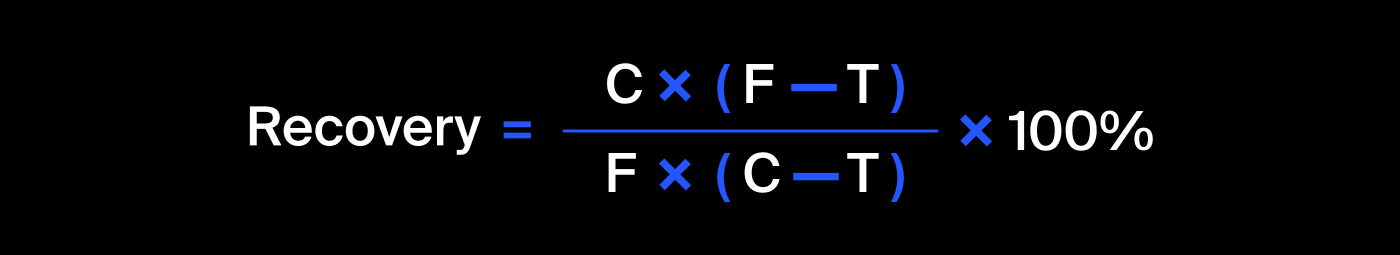

C — доля золота в концентрате после флотации/очистки;

F — доля золота в сырье/концентрате до флотации/очистки;

T — доля золота в отвальных хвостах после флотации/очистки

In [ ]:
train['rougher.output.recovery']

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64

In [ ]:
recovery = (100 * train['rougher.output.concentrate_au']*(train['rougher.input.feed_au'] - train['rougher.output.tail_au']))/(train['rougher.input.feed_au'] * (train['rougher.output.concentrate_au'] - train['rougher.output.tail_au']))

In [ ]:
recovery

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Length: 14149, dtype: float64

Найдем MAE между нашими расчётами и значением признака.

In [ ]:
mean_absolute_error(train['rougher.output.recovery'], recovery)

1.1498046842860452e-14

In [ ]:
(train['rougher.output.recovery'] - recovery).value_counts()

 0.000000e+00    5444
 1.421085e-14    3163
-1.421085e-14    3104
-2.842171e-14     964
 2.842171e-14     951
 4.263256e-14     173
-4.263256e-14     166
-7.105427e-15      56
 7.105427e-15      39
 5.684342e-14      25
 2.131628e-14      18
-5.684342e-14      18
 7.105427e-14       6
-2.131628e-14       5
 3.552714e-14       3
-7.105427e-14       3
-3.552714e-15       2
-3.552714e-14       2
-4.973799e-14       1
 8.526513e-14       1
 4.618528e-14       1
-3.197442e-14       1
-6.394885e-14       1
-1.065814e-14       1
 2.486900e-14       1
dtype: int64

Как мы можем видеть по метрике MAE ошибки в train['rougher.output.recovery'] есть, но среднее отклонеия значение крайне низкое.

### Анализ признаков

Проанализирем признаки, недоступные в тестовой выборке.

Список колонок отсутсвующих в выборке тест

In [ ]:
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке не хватает онлайн-метрик (онлайн-парметров), т.е. тех что мы не можем знать по историческим данным. 

в тесте нет 34 колонок из трейн, из них 2 колонки это таргетs (final.output.recovery, rougher.output.recovery), остальные признаки:<br>
   - выходные концентрации веществ на этапах (rougher/primary_cleaner/final.output.concentrate_хх) - 12 колонок;
   - выходные концентрации отвальных хвостов на всех этапах (rougher/primary_cleaner/secondary_cleaner/final.output.tail_хх) - 16 колонок;
   - расчетны характеристики на этапе флотации 4 колонки:(rougher.calculation.au_pb_ratio/floatbank10_sulfate_to_au_feed/floatbank11_sulfate_to_au_feed/sulfate_to_au_concentrate)
   
добавим в тест только 2 колонки с таргетами из df.

In [ ]:
test = test.join(df.loc[test.index][['final.output.recovery','rougher.output.recovery']])
test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,68.910432,88.089657
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,68.143213,88.412756
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,67.776393,87.360133
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,61.467078,83.236367


### Предобработка данных

Процент пропущенных значений в выборке тест:

In [ ]:
(100* test.isna().sum()/test.shape[0]).sort_values(ascending=False).head(15)

rougher.input.floatbank11_xanthate            0.472590
rougher.input.feed_sol                        0.396975
secondary_cleaner.state.floatbank3_a_air      0.170132
rougher.input.floatbank11_sulfate             0.151229
primary_cleaner.input.depressant              0.094518
rougher.input.floatbank10_sulfate             0.094518
primary_cleaner.input.sulfate                 0.075614
primary_cleaner.input.xanthate                0.075614
rougher.input.feed_rate                       0.056711
secondary_cleaner.state.floatbank2_a_air      0.056711
secondary_cleaner.state.floatbank2_b_air      0.037807
rougher.input.feed_size                       0.018904
secondary_cleaner.state.floatbank4_a_level    0.000000
secondary_cleaner.state.floatbank3_a_level    0.000000
rougher.state.floatbank10_f_level             0.000000
dtype: float64

Процент пропущенных значений в обучающей выборке:

In [ ]:
(100* train.isna().sum()/train.shape[0]).sort_values(ascending=False)

secondary_cleaner.output.tail_sol           11.343558
rougher.state.floatbank10_e_air              3.081490
rougher.input.floatbank11_xanthate           3.024949
primary_cleaner.output.concentrate_sol       2.021344
secondary_cleaner.state.floatbank2_a_air     1.533677
                                              ...    
rougher.state.floatbank10_d_air              0.000000
rougher.output.concentrate_au                0.000000
rougher.output.recovery                      0.000000
rougher.output.tail_pb                       0.000000
rougher.output.concentrate_ag                0.000000
Length: 86, dtype: float64

Проверим целевые признак на пропуски

In [ ]:
test['rougher.output.recovery'].isna().sum()

0

In [ ]:
test['final.output.recovery'].isna().sum()

0

In [ ]:
train['rougher.output.recovery'].isna().sum()

0

In [ ]:
train['final.output.recovery'].isna().sum()

0

Пропусков в таргетах нет. Пропуски в признаках заменим методом fillna(method='ffill'), так как в условии задачи: "соседние по времени параметры часто похожи"

In [ ]:
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')

In [ ]:
#проверка
train.isna().sum().sum()

0

In [ ]:
#проверка
test.isna().sum().sum()

0

## Анализ данных

### Анализ изменения концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

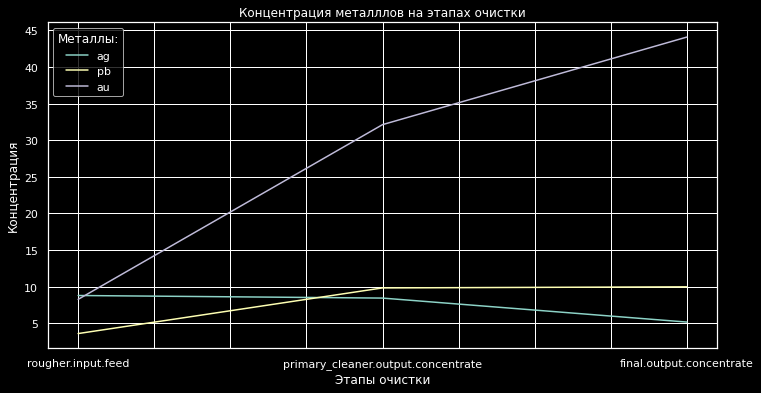

In [ ]:
df_ag = df[['rougher.input.feed_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].mean().reset_index().rename(columns={"index": "stage",  0 : "ag"})
df_pb = df[['rougher.input.feed_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].mean().reset_index().rename(columns={"index": "stage",  0 : "pb"})
df_au = df[['rougher.input.feed_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].mean().reset_index().rename(columns={"index": "stage",  0 : "au"})
df_me = df_ag.merge(df_pb, left_index=True, right_index=True)
df_me = df_me.merge(df_au, left_index=True, right_index=True)
df_me = df_me[['ag', 'pb', 'au']]
df_me['stage'] = pd.Series(['rougher.input.feed', 'primary_cleaner.output.concentrate', 'final.output.concentrate'], copy=False)
df_me.plot(x='stage',
           title = 'Концентрация металллов на этапах очистки',
           grid = True)
plt.ylabel('Концентрация')
plt.xlabel('Этапы очистки')
plt.legend(title='Металлы:')
plt.show()

Концентрация золота увеличивается, так как это и есть цель нашего процесса, также можем видеть, что увеличвается концйентрация свинца. Концентрация серебра уменьшается.

### Анализ распределения размеров гранул

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

In [ ]:
train['rougher.input.feed_size'].describe()

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [ ]:
test['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

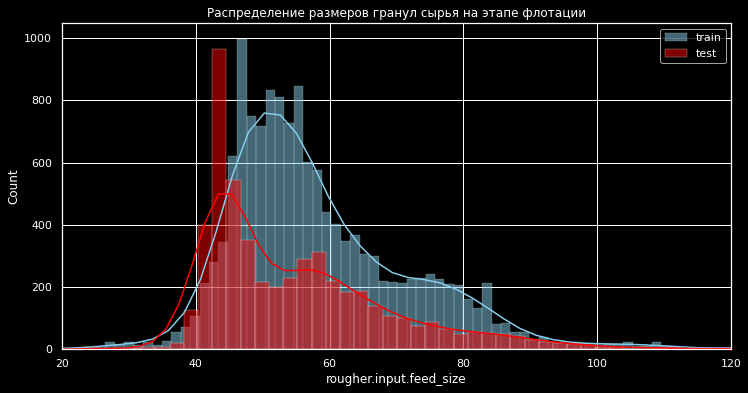

In [ ]:
graf = sns.histplot(data=train, x="rougher.input.feed_size", color="skyblue", label="train", kde=True)
graf = sns.histplot(data=test, x="rougher.input.feed_size", color="red", label="test", kde=True)

plt.title("Распределение размеров гранул сырья на этапе флотации")
graf.set(xlim=(20, 120))
plt.legend() 
plt.show()

In [ ]:
train['primary_cleaner.input.feed_size'].describe()

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

In [ ]:
test['primary_cleaner.input.feed_size'].describe()

count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

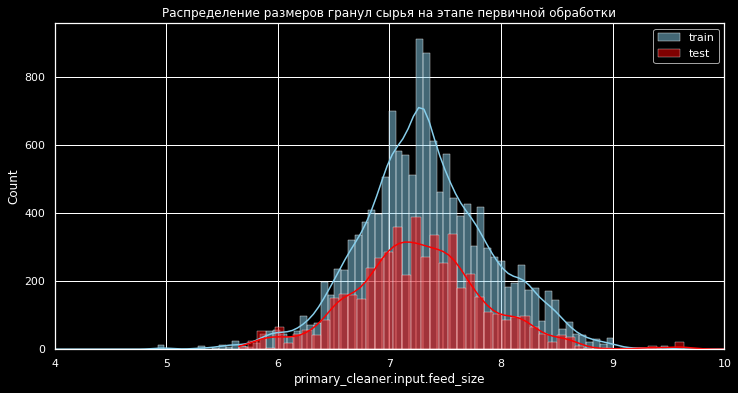

In [ ]:
graf2 = sns.histplot(data=train, x="primary_cleaner.input.feed_size", color="skyblue", label="train", kde=True)
graf2 = sns.histplot(data=test, x="primary_cleaner.input.feed_size", color="red", label="test", kde=True)

plt.title("Распределение размеров гранул сырья на этапе первичной обработки")
graf2.set(xlim=(4, 10))
plt.legend() 
plt.show()

Распределения для выборок тест и треин похожи. на первичной обработке диапазон среднего размера гранул сильно уменьшается между этапами 55 и 7.
На этапе флотации на обоих выборках видны возможные выбросы на уровне > 120.

### Анализ суммарной концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [ ]:
df['final.output.concentrate'] = df['final.output.concentrate_ag'] + df['final.output.concentrate_pb'] + df['final.output.concentrate_sol'] + df['final.output.concentrate_au']
df['rougher.input.feed'] = df['rougher.input.feed_ag'] + df['rougher.input.feed_pb'] + df['rougher.input.feed_sol'] + df['rougher.input.feed_au']
df['rougher.output.concentrate'] = df['rougher.output.concentrate_ag'] + df['rougher.output.concentrate_pb'] + df['rougher.output.concentrate_sol'] + df['rougher.output.concentrate_au']

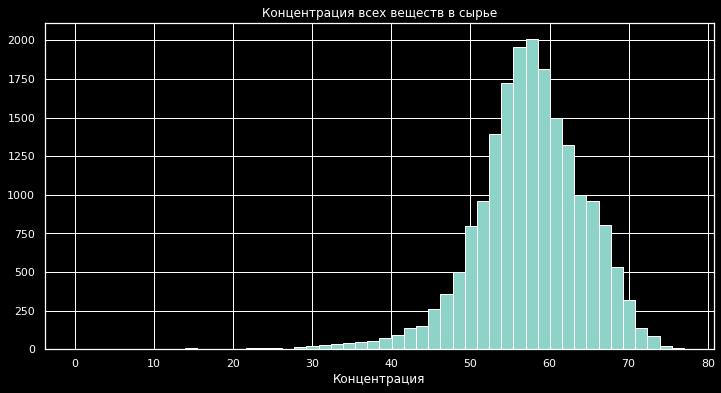

In [ ]:
df['rougher.input.feed'].hist(bins=50)
plt.xlabel('Концентрация')
plt.title('Концентрация всех веществ в сырье')
plt.show()

In [ ]:
df['rougher.input.feed'].describe()

count    19245.000000
mean        57.407926
std          7.165219
min          0.040000
25%         53.660745
50%         57.647093
75%         62.012223
max         76.978947
Name: rougher.input.feed, dtype: float64

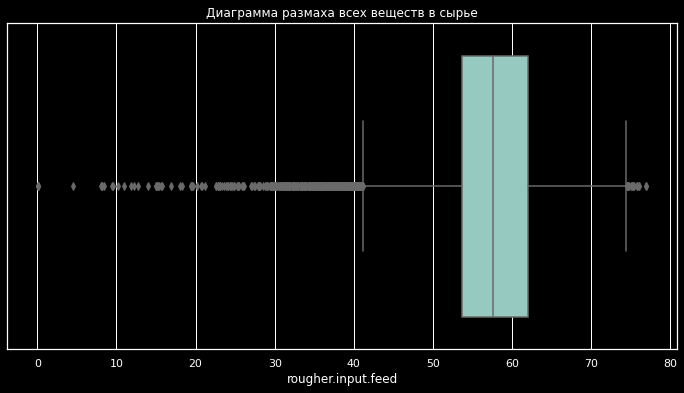

In [ ]:
sns.boxplot(x=df['rougher.input.feed'])
plt.title('Диаграмма размаха всех веществ в сырье')
plt.show()

На графиках видны аномальные значения - часть суммарных значений концентрации всех веществ равна нулю. Удалим занчения лежащие ниже миимума (выбросы).

In [ ]:
df = df.drop(index = df[df['rougher.input.feed'] < 40].index,axis = 0)

In [ ]:
df['rougher.input.feed'].describe()

count    18858.000000
mean        57.920010
std          6.170640
min         40.030178
25%         53.944562
50%         57.774472
75%         62.117108
max         76.978947
Name: rougher.input.feed, dtype: float64

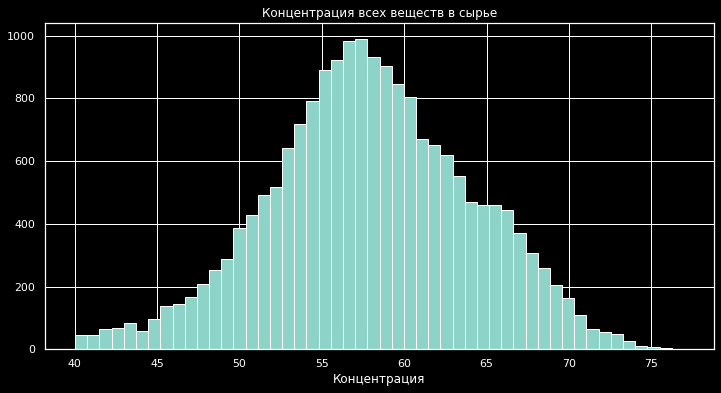

In [ ]:
df['rougher.input.feed'].hist(bins=50)
plt.xlabel('Концентрация')
plt.title('Концентрация всех веществ в сырье')
plt.show()

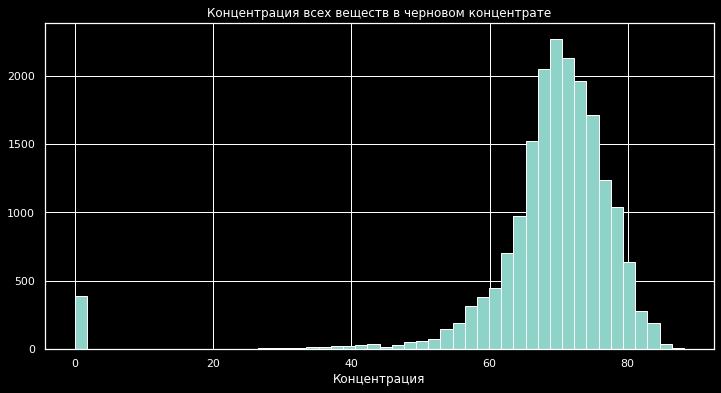

In [ ]:
df['rougher.output.concentrate'].hist(bins=50)
plt.xlabel('Концентрация')
plt.title('Концентрация всех веществ в черновом концентрате')
plt.show()

In [ ]:
df['rougher.output.concentrate'].describe()

count    19031.000000
mean        68.454287
std         12.128588
min          0.000000
25%         66.173685
50%         70.248910
75%         74.415627
max         88.140119
Name: rougher.output.concentrate, dtype: float64

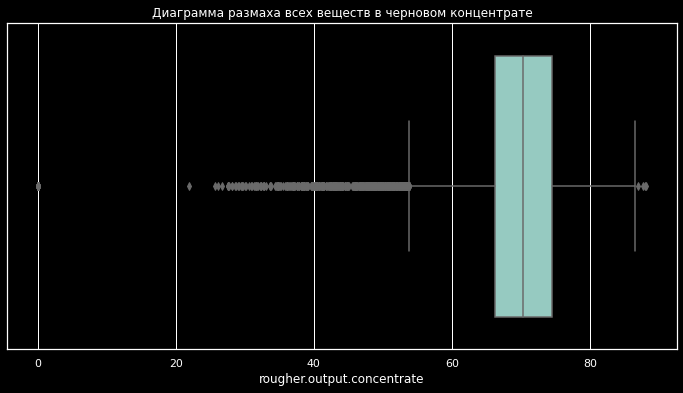

In [ ]:
sns.boxplot(x=df['rougher.output.concentrate'])
plt.title('Диаграмма размаха всех веществ в черновом концентрате')
plt.show()

На графиках видны аномальные значения - часть суммарных значений концентрации всех веществ равна нулю. Удалим занчения лежащие ниже миимума (выбросы).

In [ ]:
df = df.drop(index = df[df['rougher.output.concentrate'] < 50].index,axis = 0)

In [ ]:
df['rougher.output.concentrate'].describe()

count    18334.000000
mean        70.346060
std          6.151846
min         50.030460
25%         66.778930
50%         70.554528
75%         74.596617
max         88.140119
Name: rougher.output.concentrate, dtype: float64

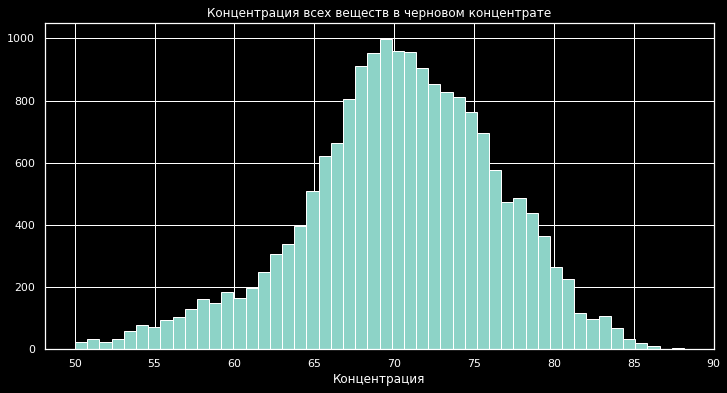

In [ ]:
df['rougher.output.concentrate'].hist(bins=50)
plt.xlabel('Концентрация')
plt.title('Концентрация всех веществ в черновом концентрате')
plt.show()

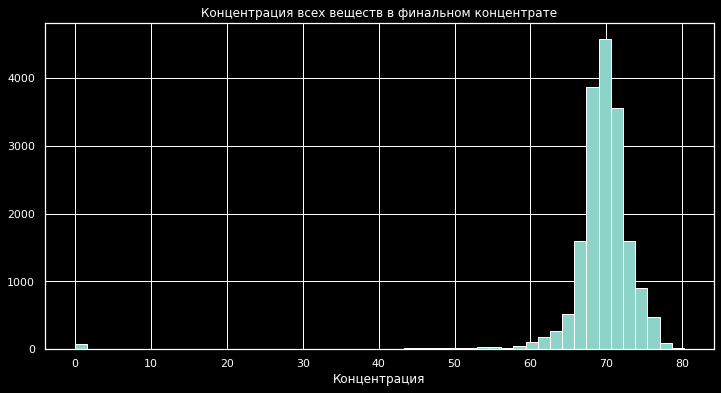

In [ ]:
df['final.output.concentrate'].hist(bins=50)
plt.xlabel('Концентрация')
plt.title('Концентрация всех веществ в финальном концентрате')
plt.show()

In [ ]:
df['final.output.concentrate'].describe()

count    18189.000000
mean        69.051746
std          6.637801
min          0.000000
25%         68.075002
50%         69.674444
75%         71.429195
max         80.210644
Name: final.output.concentrate, dtype: float64

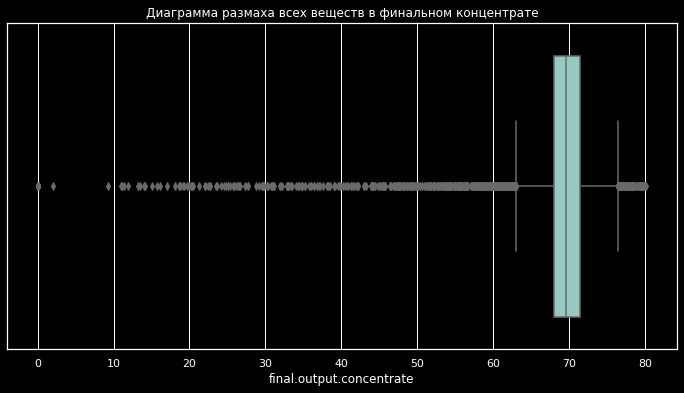

In [ ]:
sns.boxplot(x=df['final.output.concentrate'])
plt.title('Диаграмма размаха всех веществ в финальном концентрате')
plt.show()

На графиках видны аномальные значения - часть суммарных значений концентрации всех веществ равна нулю. Удалим занчения лежащие ниже миимума (выбросы).

In [ ]:
df = df.drop(index = df[df['final.output.concentrate'] < 60].index,axis = 0)

In [ ]:
df['final.output.concentrate'].describe()

count    17730.000000
mean        69.853384
std          2.789050
min         60.016164
25%         68.235126
50%         69.750855
75%         71.482068
max         80.210644
Name: final.output.concentrate, dtype: float64

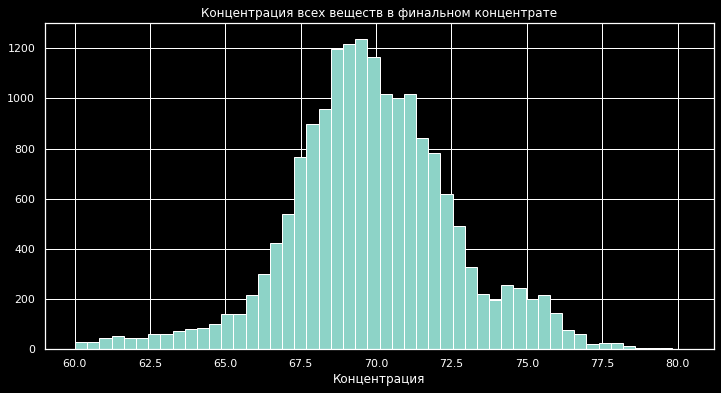

In [ ]:
df['final.output.concentrate'].hist(bins=50)
plt.xlabel('Концентрация')
plt.title('Концентрация всех веществ в финальном концентрате')
plt.show()

## Модель

### Функция для вычисления итоговой sMAPE

In [ ]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [ ]:
def result_smape(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

In [ ]:
smape_scorer = make_scorer(smape, greater_is_better=False)

### Подготовка данных для моделей

Удаляем признаки из трейн в соответствии с тест, так как это онлайн метрики

In [ ]:
train = train[test.columns]

In [ ]:
X_train = train.drop(['final.output.recovery','rougher.output.recovery'], axis=1)
y_train = train[['final.output.recovery','rougher.output.recovery']]
X_test = test.drop(['final.output.recovery','rougher.output.recovery'], axis=1)
y_test = test[['final.output.recovery','rougher.output.recovery']]

In [ ]:
X_train.shape, X_test.shape

((14149, 52), (5290, 52))

Выполним масштабирование

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)

### Модель линейной регресии

In [ ]:
model_lr = LinearRegression()
score = cross_val_score(model_lr, X_train, y_train['final.output.recovery'], scoring=smape_scorer, cv=5).mean()
print('Средняя smape: %.2f'%score)

Средняя smape: -12.25


In [ ]:
model_lr = LinearRegression()
score = cross_val_score(model_lr, X_train, y_train['rougher.output.recovery'], scoring=smape_scorer, cv=5).mean()
print('Средняя smape: %.2f'%score)

Средняя smape: -12.80


### Модель DecisionTreeClassifier

In [ ]:
model_dtr = DecisionTreeRegressor(random_state=12345)
score = cross_val_score(model_dtr, X_train, y_train['final.output.recovery'], scoring=smape_scorer, cv=5).mean()
print('Средняя smape: %.2f'%score)

Средняя smape: -22.29


In [ ]:
model_dtr = DecisionTreeRegressor(random_state=12345)
score = cross_val_score(model_dtr, X_train, y_train['rougher.output.recovery'], scoring=smape_scorer, cv=5).mean()
print('Средняя smape: %.2f'%score)

Средняя smape: -18.86


### RandomForestRegressor

In [ ]:
grid = RandomizedSearchCV(RandomForestRegressor(random_state=12345), scoring=smape_scorer, n_iter=5,
                    param_distributions = {'max_depth': [None, 2,3,5], 'max_features' : ['auto','sqrt', 'log2'], 'n_estimators': [10,100],}, cv = 5)
grid.fit(X_train,  y_train['final.output.recovery'])
print('\nBest smape: %.2f'%grid.best_score_, ' Best Params : ', str(grid.best_params_))


Best smape: -10.31  Best Params :  {'n_estimators': 10, 'max_features': 'auto', 'max_depth': 3}


In [ ]:
grid = RandomizedSearchCV(RandomForestRegressor(random_state=12345), scoring=smape_scorer, 
                    param_distributions = {'max_depth': [None, 2,3,5], 'max_features' : ['auto','sqrt', 'log2'],
                                           'n_estimators': [10,100],}, cv = 5)
grid.fit(X_train,  y_train['rougher.output.recovery'])
print('Best smape: %.2f'%grid.best_score_, ' Best Params : ', str(grid.best_params_))

Best smape: -10.70  Best Params :  {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 5}


### Catboost

In [ ]:
cat = CatBoostRegressor()
grid = RandomizedSearchCV(estimator=cat, param_distributions = {'depth': [1, 2]}, cv = 5)
grid.fit(X_train,  y_train['rougher.output.recovery'])
print('Best smape: %.2f'%grid.best_score_, ' Best Params : ', str(grid.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Выходные данные были обрезаны до нескольких последних строк (5000).
5:	learn: 14.5950822	total: 25.7ms	remaining: 4.26s
6:	learn: 14.5045241	total: 31.9ms	remaining: 4.53s
7:	learn: 14.4236443	total: 36ms	remaining: 4.46s
8:	learn: 14.3473532	total: 40.1ms	remaining: 4.42s
9:	learn: 14.2643490	total: 43.8ms	remaining: 4.33s
10:	learn: 14.2033756	total: 47.4ms	remaining: 4.26s
11:	learn: 14.1369530	total: 52.1ms	remaining: 4.29s
12:	learn: 14.0744176	total: 56.7ms	remaining: 4.3s
13:	learn: 14.0201800	total: 61ms	remaining: 4.29s
14:	learn: 13.9565331	total: 65.2ms	remaining: 4.28s
15:	learn: 13.9071512	total: 69.4ms	remaining: 4.27s
16:	learn: 13.8543675	total: 73.2ms	remaining: 4.23s
17:	learn: 13.8045177	total: 77.3ms	remaining: 4.22s
18:	learn: 13.7646828	total: 81.5ms	remaining: 4.21s
19:	learn: 13.7229377	total: 87.2ms	remaining: 4.28s
20:	learn: 13.6777018	total: 91.5ms	remaining: 4.26s
21:	learn: 13.6371232	total: 96.1ms	remaining: 4.27s
22:	learn: 13.5991060	total: 100ms	remain

In [ ]:
cat = CatBoostRegressor()
grid = RandomizedSearchCV(estimator=cat, param_distributions = {'depth': [1, 2]}, cv = 5)
grid.fit(X_train,  y_train['final.output.recovery'])
print('Best smape: %.2f'%grid.best_score_, ' Best Params : ', str(grid.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Выходные данные были обрезаны до нескольких последних строк (5000).
5:	learn: 9.9466179	total: 25.9ms	remaining: 4.28s
6:	learn: 9.8726649	total: 29.8ms	remaining: 4.23s
7:	learn: 9.8036889	total: 33.8ms	remaining: 4.2s
8:	learn: 9.7339845	total: 38.4ms	remaining: 4.22s
9:	learn: 9.6705515	total: 42.8ms	remaining: 4.23s
10:	learn: 9.6073685	total: 46.8ms	remaining: 4.21s
11:	learn: 9.5498600	total: 51ms	remaining: 4.2s
12:	learn: 9.5053548	total: 55.5ms	remaining: 4.22s
13:	learn: 9.4582782	total: 60.2ms	remaining: 4.24s
14:	learn: 9.4135952	total: 64.4ms	remaining: 4.23s
15:	learn: 9.3674852	total: 68.3ms	remaining: 4.2s
16:	learn: 9.3271375	total: 72.7ms	remaining: 4.21s
17:	learn: 9.2820775	total: 77ms	remaining: 4.2s
18:	learn: 9.2452922	total: 81.4ms	remaining: 4.2s
19:	learn: 9.1930711	total: 85.1ms	remaining: 4.17s
20:	learn: 9.1564395	total: 89.2ms	remaining: 4.16s
21:	learn: 9.1094955	total: 93.2ms	remaining: 4.14s
22:	learn: 9.0664971	total: 97.4ms	remaining: 4.14s
23:	learn:

In [ ]:
cat = CatBoostRegressor(depth = 1)
score = cross_val_score(cat, X_train, y_train['rougher.output.recovery'], scoring=smape_scorer, cv=5).mean()
print('Средняя smape: %.2f'%score)

Выходные данные были обрезаны до нескольких последних строк (5000).
5:	learn: 14.6980407	total: 18.2ms	remaining: 3.01s
6:	learn: 14.6460760	total: 21ms	remaining: 2.98s
7:	learn: 14.5987487	total: 24ms	remaining: 2.97s
8:	learn: 14.5537863	total: 26.9ms	remaining: 2.97s
9:	learn: 14.5061949	total: 29.9ms	remaining: 2.96s
10:	learn: 14.4587109	total: 33ms	remaining: 2.97s
11:	learn: 14.4134458	total: 36ms	remaining: 2.96s
12:	learn: 14.3719413	total: 38.7ms	remaining: 2.94s
13:	learn: 14.3323119	total: 41.4ms	remaining: 2.92s
14:	learn: 14.2911360	total: 44.4ms	remaining: 2.92s
15:	learn: 14.2560379	total: 47.3ms	remaining: 2.91s
16:	learn: 14.2282124	total: 50.3ms	remaining: 2.91s
17:	learn: 14.1912006	total: 53.3ms	remaining: 2.91s
18:	learn: 14.1594418	total: 56.1ms	remaining: 2.89s
19:	learn: 14.1304806	total: 59ms	remaining: 2.89s
20:	learn: 14.1044377	total: 61.9ms	remaining: 2.89s
21:	learn: 14.0746839	total: 64.9ms	remaining: 2.88s
22:	learn: 14.0435368	total: 67.7ms	remaining:

In [ ]:
cat = CatBoostRegressor(depth = 1)
score = cross_val_score(cat, X_train, y_train['final.output.recovery'], scoring=smape_scorer, cv=5).mean()
print('Средняя smape: %.2f'%score)

Выходные данные были обрезаны до нескольких последних строк (5000).
5:	learn: 9.9640086	total: 18ms	remaining: 2.98s
6:	learn: 9.9132403	total: 20.9ms	remaining: 2.97s
7:	learn: 9.8692996	total: 23.9ms	remaining: 2.96s
8:	learn: 9.8256933	total: 26.8ms	remaining: 2.96s
9:	learn: 9.7841959	total: 30ms	remaining: 2.97s
10:	learn: 9.7449516	total: 33.4ms	remaining: 3s
11:	learn: 9.7052172	total: 36.2ms	remaining: 2.98s
12:	learn: 9.6693482	total: 38.9ms	remaining: 2.95s
13:	learn: 9.6364598	total: 41.8ms	remaining: 2.94s
14:	learn: 9.6025687	total: 44.8ms	remaining: 2.94s
15:	learn: 9.5723697	total: 47.8ms	remaining: 2.94s
16:	learn: 9.5405089	total: 50.7ms	remaining: 2.93s
17:	learn: 9.5114407	total: 53.6ms	remaining: 2.92s
18:	learn: 9.4849156	total: 56.5ms	remaining: 2.92s
19:	learn: 9.4583419	total: 59.4ms	remaining: 2.91s
20:	learn: 9.4315567	total: 62.3ms	remaining: 2.9s
21:	learn: 9.4064995	total: 65.2ms	remaining: 2.9s
22:	learn: 9.3826298	total: 68ms	remaining: 2.89s
23:	learn: 9

Лучший скор по smape показал RandomForestRegressor.

### Проверка качества лучшей модели на тестовой выборке

In [ ]:
model_rfr = RandomForestRegressor(random_state=12345, n_estimators=100, max_features='sqrt', max_depth=5)
model_rfr_final = model_rfr.fit(X_train,y_train['final.output.recovery'])
predicted_valid_rfr_final = model_rfr_final.predict(X_test)
smape_final = smape(y_test['final.output.recovery'], predicted_valid_rfr_final)
print('smape_final :', smape_final)

smape_final : 10.257509321934975


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
model_rfr = RandomForestRegressor(random_state=12345, n_estimators=10, max_features='sqrt', max_depth=5)
model_rfr_rougher = model_rfr.fit(X_train,y_train['rougher.output.recovery'])
predicted_valid_rfr_rougher = model_rfr_rougher.predict(X_test)
smape_rougher = smape(y_test['rougher.output.recovery'], predicted_valid_rfr_rougher)
print('smape_rougher :', smape_rougher)

smape_rougher : 25.71904702751495


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
result_smape(smape_rougher, smape_final)

14.122893748329968

Сравним нашу модель с DummyRegressor

In [ ]:
model_dr = DummyRegressor(strategy="median")
model_dr_rougher = model_dr.fit(X_train,y_train['rougher.output.recovery'])
model_dr_final = model_dr.fit(X_train,y_train['final.output.recovery'])
predicted_valid_dr_rougher = model_dr_rougher.predict(X_test)
predicted_valid_dr_final = model_dr_final.predict(X_test)
smape_rougher = smape(y_test['rougher.output.recovery'], predicted_valid_dr_rougher)
smape_final = smape(y_test['final.output.recovery'], predicted_valid_dr_final)
print('smape_rougher dr:',smape_rougher)
print('smape_final dr:', smape_final)
print('result_smape dr:',result_smape(smape_rougher, smape_final))

smape_rougher dr: 28.396256811840523
smape_final dr: 9.76398250818525
result_smape dr: 14.422051084099069


RandomForestRegressor лучше DummyRegressor, но не намного. Попробуем DecisionTreeRegresso

In [ ]:
model_dtr_rougher = model_dtr.fit(X_train,y_train['rougher.output.recovery'])
predicted_valid_dtr_rougher = model_dtr_rougher.predict(X_test)
smape_rougher_dtr = smape(y_test['rougher.output.recovery'], predicted_valid_dtr_rougher)
smape_rougher_dtr

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


9.123228033978034

In [ ]:
model_dtr_final = model_dtr.fit(X_train,y_train['final.output.recovery'])
predicted_valid_dtr_final = model_dtr_final.predict(X_test)
smape_final_dtr = smape(y_test['final.output.recovery'], predicted_valid_dtr_final)
smape_final_dtr

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


11.280698527357227

In [ ]:
print('result_smape dtr:', result_smape(smape_rougher_dtr, smape_final_dtr))

result_smape dtr: 10.741330904012429


<b>Вывод:</b><br>
Итоговое smape DecisionTreeRegresso гораздо лучше. По видимому у RandomForestRegressor произошло переобучение моедли. Остановим свой выбор на DecisionTreeRegressor

## Вывод

В ходе работы были выполнены следующие этапа:
- Подготовка данных: 
    - чтение файлов
    - проверка расчетов
    - анализ признаков
    - предобработка данных
- Исследовательский анализ данных;
    - анализ изменения концентрация металлов (Au, Ag, Pb) на различных этапах очистки
    - анализ распределения размеров гранул
    - анализ суммарной концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах
- Построение и обучение модели:
    - обучены модели линейной регрессии, дерева решений, случайного леса и catboost. 
    - с помощью кроссвалидации определна наиболее эфективная модель
    - модель проверена на тестовой выборке.

В результате работы разработана модель позволяющая предсказывать коэффициент восстановления золота из золотосодержащей руды, используя данные с параметрами добычи и очистки. 